In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import matplotlib.cm as cm
import cPickle as pickle
import helpers
import fwd_sample as fs
import pymc3 as pm
reload(helpers)

<module 'helpers' from 'helpers.pyc'>

# Figure directories

In [15]:
local_dir = 'paper_figures/'
paper_dir = '/home/tmcgrath/Dropbox/Apps/ShareLaTeX/CLAMS to PLoS CB/figures/'
data_dir = 'new_all_data/'

# Import PyMC3 traces

In [16]:
#trace = pickle.load(open("PYY_Lep_8hr_trace.p", "r"))
#subj_data = pickle.load(open("PYY_Lep_8hr_subj.p", "r"))

trace = pickle.load(open("new_all_data2_trace.p", "rb"))
subj_data = pickle.load(open("new_all_data2_subj.p", "rb"))

# Create colourmappers and marker styles

In [17]:
## Create dose colourmapper
## PYY
PYY_dict = {1.5:5, 7.5:8, 300.0:10}
PYY_norm = mpl.colors.Normalize(vmin = 0.0,
                                vmax = 10)

PYY_cmap = cm.Greens

PYY_dose_col = cm.ScalarMappable(norm=PYY_norm, cmap=PYY_cmap)

## Create day/night line and marker style
period_ms = {'L':'o', 'D':'^'}
period_ls = {'L':'-', 'D':'--'}

# Create group and individual lists

In [18]:
## Create metadata holder
metadata = []
groups = []

for i in subj_data:
    x = []
    group = i[0].split('/')[1]
    x.append(group)
    x += i[1].split('_')
    
    metadata.append(x)
    
    if group not in groups:
        groups.append(group)
        
group_id_dict = {}
for i, group_name in enumerate(groups):
    group_id_dict[i] = group_name
    
group_list = np.arange(len(groups))

# Group indexing

In [19]:
## Index mask
rat_idx = np.unique(trace['theta1'][0,:], return_index=True)[1]
rat_idx = sorted(rat_idx)

## Subject data
subj_labels = []

for i in subj_data:
    subj_labels.append(i[1].split('_'))
    
subj_labels = np.array(subj_labels)

## Amount colourmapper
amts_save = []
for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    data = subj_labels[i]    
    path = data_dir + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = helpers.amt_from_file(path, filename)
    amts_save.append(amt)
    
amt_norm = mpl.colors.Normalize(vmin = min(amts_save),
                                vmax = max(amts_save))

cmap = cm.plasma

amt_col = cm.ScalarMappable(norm=amt_norm, cmap=cmap)

# Figure 2a - cumulative feeding curves

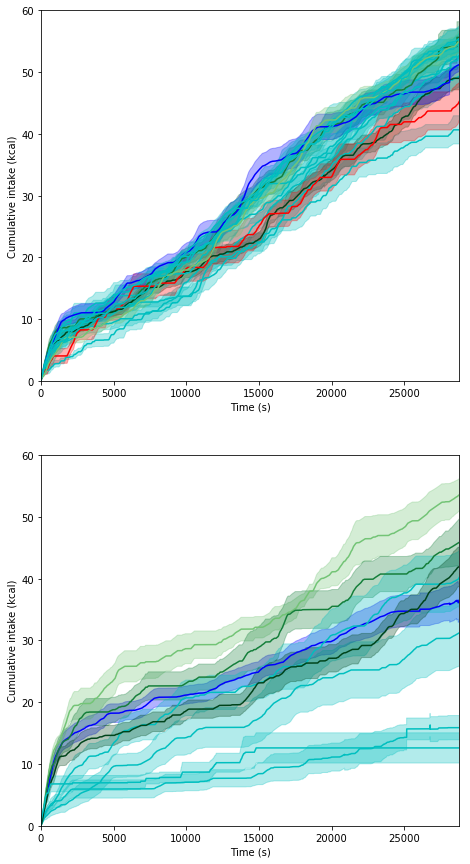

In [ ]:
reload(helpers)

def plot_c_feeding(folder, ax, c='b', ls='-'):
    data = helpers.group_c_feeding(folder)
    foo = ~np.isnan(data) # count not-nan entries
    n = np.count_nonzero(foo, axis=0) # recalculate sample size at each t to correctly calculate SEM
    
    mean_ts = np.nanmean(data, axis=0)
    t = np.arange(len(mean_ts))
    
    std_ts = np.nanstd(data, axis=0)
    sem_ts = std_ts/np.sqrt(n)
    ax.plot(t, mean_ts, c=c, ls=ls)
    ax.fill_between(t, mean_ts - sem_ts, mean_ts+sem_ts, alpha=0.3, color=c)
    #ax.fill_between(t, mean_ts - std_ts, mean_ts+std_ts, alpha=0.3, color=c)

## Now plot the data
fig, axes = plt.subplots(2,1, figsize=(7.5,15)) # axes[0] for dark, axes[1] for light

root = data_dir

for folder in os.listdir(root):
    data = folder.split('_')
    c = helpers.get_colour(data)
    path = '/'.join([root, folder]) + '/'
    
    if data[3] == 'D':
        plot_c_feeding(path, axes[0], c=c)
        
    elif data[3] == 'L':
        plot_c_feeding(path, axes[1], c=c)
        
    else:
        print "ERROR in folder ", folder
        
## Axis labelling
axes[0].set_xlabel('Time (s)')
axes[1].set_xlabel('Time (s)')
axes[0].set_ylabel('Cumulative intake (kcal)')
axes[1].set_ylabel('Cumulative intake (kcal)')

## Generate main figure     
axes[0].set_xlim([0, 28800])
axes[0].set_ylim([0, 60])
axes[1].set_xlim([0, 28800])
axes[1].set_ylim([0, 60])

#plt.savefig(local_dir+'fig2a.svg')
#plt.savefig(paper_dir+'fig2a.svg')

## Generate short-time inset figure
#axes[0].set_xlim([0, 1800])
#axes[0].set_ylim([0, 12.5])
#axes[1].set_xlim([0, 1800])
#axes[1].set_ylim([0, 20])

#plt.savefig(local_dir+'fig2a_inset.svg')
#plt.savefig(paper_dir+'fig2a_inset.svg')

plt.show()

# Figure 2b - the model accurately recapitulates feeding behaviour summary statistics

In [ ]:
## Plot true group mean
## distribution generated by posterior mean
## and full posterior distribution
import fwd_sample as fs
reload(helpers)
reload(fs)

num_boots = 100

fig, axes = plt.subplots(1)

## Boxplot experimental data
labels = []
data = []
true_means = []
for folder in os.listdir(data_dir):
    labels.append(folder)
    samples = []
    amts = helpers.group_amts(data_dir+'/'+folder+'/')
    true_means.append(3.5*np.mean(amts))
    for i in range(0, num_boots):
        kcals = 3.5*np.mean(np.random.choice(amts, size=len(amts))) # 3.5 for g -> kcal
        samples.append(kcals)
        
    data.append(samples)
    
data = np.array(data)
print data.shape
print len(labels)
axes.boxplot(data.T, labels=labels)
axes.scatter(1+np.arange(len(true_means)), true_means)


## Boxplot posterior samples

## make group : index dictionary
cats = []
for i in subj_data:
    name = i[0].split('/')[1]
    if name not in cats:
        cats.append(name)
        
group_dict = {}
for i, cat in enumerate(cats):
    group_dict[cat] = i
    
print group_dict
        
## now do the sampling
trace_size = trace['mu'].shape[0]

num_animals = 10
x0 = 0

all_qtys = []
for folder in os.listdir(data_dir):
    cat_idx = group_dict[folder]
    
    cat_means = []
    
    if folder.split('_')[2] == 'N':
        print "long duration for ", folder
        tmax = 24*3600
    else:
        tmax = 8*3600
        
    for j in range(0, num_boots):
        theta_idx = np.random.randint(trace_size)
        mu, cov = helpers.sample_group(trace, cat_idx, theta_idx)
        
        thetas = np.random.multivariate_normal(mu, cov, size=num_animals)
        amts = []
        
        for theta_set in thetas:
            try:
                val = fs.sample(tmax, theta_set, x0)[1]
            except ValueError:
                val = fs.sample(tmax, theta_set, x0)[1]
            amts.append(3.5*val)
            
        cat_means.append(np.mean(amts))
        
    all_qtys.append(cat_means)
    print folder, np.mean(cat_means)

all_qtys = np.array(all_qtys)
print all_qtys.shape
axes.boxplot(all_qtys.T, labels=labels)

# Plot formatting
for tick in axes.get_xticklabels():
    tick.set_rotation(-90)

axes.set_ylim([40, 80])

plt.show()

plt.show()

(21, 100)
21
{'PYY_7.5_R_L': 5, 'GLP-1_100.0_A_D': 14, 'sib_0.9_A_D': 13, 'GLP-1_300.0_A_D': 11, 'Ex-4_0.3_A_D': 19, 'PYY_300.0_A_D': 4, 'LiCl_32.0_A_D': 18, 'LiCl_64.0_R_L': 8, 'LiCl_16.0_R_L': 17, 'LiCl_32.0_R_L': 3, 'vehicle_0.0_A_D': 1, 'saline_0.0_A_L': 7, 'GLP-1_30.0_A_D': 2, 'PYY_7.5_A_D': 10, 'Lep_2.0_A_D': 20, 'saline_0.0_A_D': 9, 'PYY_1.5_A_D': 6, 'PYY_1.5_R_L': 12, 'PYY_300.0_R_L': 0, 'saline_0.0_R_D': 15, 'saline_0.0_R_L': 16}
vehicle_0.0_A_D 59.3655670561
LiCl_32.0_A_D 49.7040125639
PYY_7.5_A_D 57.9493188503


In [ ]:
ordered_labels = ['saline_0.0_R_D', 'PYY_1.5_R_D', 'PYY_7.5_R_D', 'PYY_300.0_R_D',
                  'saline_0.0_R_L', 'PYY_1.5_R_L', 'PYY_7.5_R_L', 'PYY_300.0_R_L',
                  'saline_0.0_N_L', 'saline_0.0_N_D']

## Create folder dictionary to aid with plotting
folder_dict = {}
for i, folder in enumerate(os.listdir(data_dir)):
    folder_dict[folder] = i

## Now do the plotting
fig, axes = plt.subplots(2, 1)

plotting_data = data
plotting_samples = all_qtys

data_to_plot = []
samples_to_plot = []

for label in ordered_labels:
    print label, folder_dict[label], group_dict[label]
    data_to_plot.append(plotting_data[folder_dict[label]])
    samples_to_plot.append(plotting_samples[folder_dict[label]])

positions = 3*np.arange(len(true_means)) + 1

data_to_plot = np.array(data_to_plot)
samples_to_plot = np.array(samples_to_plot)

print data_to_plot.shape

data_boxes = axes[1].boxplot(data_to_plot.T, positions=positions, labels=ordered_labels, widths=0.6)
sample_boxes = axes[1].boxplot(samples_to_plot.T, positions=positions+1, labels=ordered_labels, widths=0.6)

plt.setp(sample_boxes['boxes'], color='red')
plt.setp(sample_boxes['whiskers'], color='red')
plt.setp(sample_boxes['fliers'], color='red', marker='+')

axes[0].boxplot(data.T, positions=positions, labels=labels, widths=0.6)
axes[0].boxplot(all_qtys.T, positions=positions+1, labels=labels, widths=0.6)

# Plot formatting
for tick in axes[0].get_xticklabels():
    tick.set_rotation(-90)

axes[0].set_xticks(positions+0.5)
axes[0].set_xlim([0, 30])
#axes[0].set_ylim([30, 80])

# Plot formatting
for tick in axes[1].get_xticklabels():
    tick.set_rotation(-90)

axes[1].set_xticks(positions+0.5)
axes[1].set_xlim([0, 30])
axes[1].set_ylim([30, 80])
    
plt.show()

# Figure 2c - mean dose-dependent effect of PYY on short-term feeding is partially compensatory and changes based on photoperiod

In [ ]:
reload(helpers)
fig1, axes1 = helpers.group_hist(trace, group_list, group_id_dict, 0, recip=True)
fig2, axes2 = helpers.group_hist(trace, group_list, group_id_dict, 1, recip=False)

axes1[0].set_xlim([0, 400])
axes1[1].set_xlim([0, 400])

axes2[0].set_xlim([0.002, 0.009])
axes2[1].set_xlim([0.002, 0.009])

plt.show()

# Figure 2d - meal termination decisions are substantially affected by photoperiod and high-dose PYY, but are otherwise similar

In [ ]:
import pymc3 as pm
reload(helpers)

percentile = 5
fig, axes = plt.subplots(2,1, figsize=(7.5, 15))


## Do the plotting
for i in group_list:
    theta5 = trace['mu'][::,i,3]
    theta6 = trace['mu'][::,i,4]

    xvals = np.linspace(0, 30, 1000)

    sig_min, sig_mean, sig_max, sig_int = helpers.get_Q(xvals, theta5, theta6, percentile)
    
    ## Formatting stuff
    data = group_id_dict[i].split('_')
    c = helpers.get_colour(data)

    ## Plot using the formatting
    if data[3] == 'D':
        axes[0].plot(xvals, sig_mean, c=c)
        axes[0].fill_between(xvals, sig_min, sig_max, alpha=0.1, color=c)
        #axes[0].fill_between(xvals, sig_int[:,0], sig_int[:,1], alpha=0.1, color=c)
        
    elif data[3] == 'L':
        axes[1].plot(xvals, sig_mean, c=c)
        axes[1].fill_between(xvals, sig_min, sig_max, alpha=0.1, color=c)
        
    else:
        raise ValueError

print sig_int.shape
print xvals.shape

plt.savefig(local_dir+'fig2d.svg')
plt.savefig(paper_dir+'fig2d.svg')        
        
plt.show()

# Figure 2e - Dose-dependent effects of PYY on long pause duration, but only normal light period feeding tracks stomach fullness

In [ ]:
import scipy

def l_pause(p_lengths, g_ends, theta8, theta9):
    k1 = 0.00055
    t_cs = 2.*np.sqrt(g_ends)/k1
    
    theta8 = np.power(10., theta8)
    theta9 = np.power(10., theta9)

    g_pausing_1 = 0.25*(k1*p_lengths)**2 - np.sqrt(g_ends)*k1*p_lengths + g_ends

    phi_L_1 = 1./(theta8 + theta9*g_pausing_1)

    psi_L_1 = 2.*np.arctan(0.5*np.sqrt(theta9/theta8)*(k1*p_lengths - 2.*np.sqrt(g_ends)))
    psi_L_1 = psi_L_1 - 2.*np.arctan(0.5*np.sqrt(theta9/theta8)*(-2.*np.sqrt(g_ends)))
    psi_L_1 = psi_L_1/(k1*np.sqrt(theta8*theta9))

    ll_L_1 = np.log(phi_L_1) - psi_L_1

    
    phi_L_2 = 1./theta8

    psi_L_2 = 2.*np.arctan(0.5*np.sqrt(theta9/theta8)*(k1*t_cs - 2.*np.sqrt(g_ends)))
    psi_L_2 = psi_L_2 - 2.*np.arctan(0.5*np.sqrt(theta9/theta8)*(-2.*np.sqrt(g_ends)))
    psi_L_2 = psi_L_2/(k1*np.sqrt(theta8*theta9))

    psi_L_2 = psi_L_2 + (p_lengths-t_cs)/theta8

    ll_L_2 = np.log(phi_L_2) - psi_L_2
        
    ll_L = np.where(p_lengths < t_cs, ll_L_1, ll_L_2)
        
    return ll_L

l_pause_vec = np.vectorize(l_pause)

resamples = 1

def integrand(t, x0, theta8, theta9):
    return t * np.exp(l_pause_vec(t, x0, theta8, theta9))

fig, axes = plt.subplots(2, 1, figsize=(7.5,15))
x = np.arange(15)

for group_id in group_list:
    print group_id
    count = 0
    sample_holder = []
    while count < resamples:
        i = np.random.randint(trace['mu'].shape[0]) # randomly sample from posterior
        theta8 = trace['mu'][i,group_id,6]
        theta9 = trace['mu'][i,group_id,7]

        ## Integrate along posterior
        y = []
        for x0 in x:
            y.append(scipy.integrate.quad(integrand, 0, np.inf, args=(x0, theta8, theta9))[0])

        sample_holder.append(y)

        count += 1

    sample_holder = np.array(sample_holder)
    t = np.mean(sample_holder, axis=0)
    std = np.std(sample_holder, axis=0)
    
    ## Formatting stuff
    group_data = groups[group_id].split('_')
    dose = float(group_data[1])
    label = group_id_dict[group_id]
    
    c_dose = helpers.get_colour(group_data)
    ls = '-'

    ## Now do the actual plotting
    if group_data[3] == 'D':
        axes[0].plot(x, t, c=c_dose, label=label, ls=ls)
        axes[0].fill_between(x, t-std, t+std, color=c_dose, alpha=0.3)
    else:
        axes[1].plot(x, t, c=c_dose, label=label, ls=ls)
        axes[1].fill_between(x, t-std, t+std, color=c_dose, alpha=0.3)

## Plot stomach emptying time
k1 = 0.00055
t_cs = 2.*np.sqrt(x)/k1
axes[0].plot(x, t_cs, c='k', ls='--')

## Plot axes etc
axes[0].set_xlabel('Initial stomach fullness')
axes[1].set_xlabel('Initial stomach fullness')
axes[0].set_ylabel('Mean intermeal period')
plt.show()

In [ ]:
theta9 = trace['mu'][:,9,5]
theta9_2 = trace['mu'][:,1,5]

plt.hist(theta9, color='r')
plt.hist(theta9_2, color='b')
plt.show()

In [ ]:
for i in group_id_dict.keys():
    print i, group_id_dict[i]